The goal of this notebook is to build a food classification model using transfer learning and fine-tuning on the EfficientNetV2B0 model architecture and training on the Food_101 dataset found here: https://www.kaggle.com/datasets/kmader/food41.

In [ ]:
# Extracting the data. (The original data comes as train and test data. I split the test data in half to create a validation set,
# and then zipped it together to be able to store it on Google drive while I was working on this notebook.)
!mkdir data
!cp -r /content/drive/MyDrive/food101_2.zip data
import zipfile
zip_ref = zipfile.ZipFile("data/food101_2.zip", "r")
zip_ref.extractall(path="data")
zip_ref.close()

In [ ]:
# Ensuring all data is present
import os
for dirpath, dirnames, filenames in os.walk("/content/data/content/all_food_classes"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 3 directories and 0 images in '/content/data/content/all_food_classes'
There are 101 directories and 0 images in '/content/data/content/all_food_classes/train'
There are 0 directories and 750 images in '/content/data/content/all_food_classes/train/club_sandwich'
There are 0 directories and 750 images in '/content/data/content/all_food_classes/train/poutine'
There are 0 directories and 750 images in '/content/data/content/all_food_classes/train/lobster_bisque'
There are 0 directories and 750 images in '/content/data/content/all_food_classes/train/baklava'
There are 0 directories and 750 images in '/content/data/content/all_food_classes/train/bibimbap'
There are 0 directories and 750 images in '/content/data/content/all_food_classes/train/takoyaki'
There are 0 directories and 750 images in '/content/data/content/all_food_classes/train/beef_tartare'
There are 0 directories and 750 images in '/content/data/content/all_food_classes/train/caesar_salad'
There are 0 directories and 7

In [ ]:
# Formatting data
import tensorflow as tf
IMG_SIZE = (224, 224)

train_directory = "/content/data/content/all_food_classes/train"
val_directory = "/content/data/content/all_food_classes/valid"
test_directory = "/content/data/content/all_food_classes/test"

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_directory,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE).prefetch(tf.data.AUTOTUNE)

val_data = tf.keras.preprocessing.image_dataset_from_directory(val_directory,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE).prefetch(tf.data.AUTOTUNE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_directory,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False).prefetch(tf.data.AUTOTUNE)

Found 75750 files belonging to 101 classes.
Found 12625 files belonging to 101 classes.
Found 12625 files belonging to 101 classes.


In [ ]:
# Creating a data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

aug_layer = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2)
], name="aug_layer")

In [ ]:
# Import base model (EfficientNetV2B0) and add top layers
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False # Freezing all layers for feature extraction

# Building feature extraction model
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = aug_layer(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="GAP_layer")(x)
# There are 101 classes in the Food101 dataset
outputs = layers.Dense(101, activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
checkpoint_path = "data/model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [ ]:
# Compiling the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# Fitting the model
history_1 = model.fit(train_data,
                      epochs=3,
                      validation_data=val_data,
                      callbacks=[checkpoint_callback])

Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 420s 160ms/step - accuracy: 0.3622 - loss: 2.7912 - val_accuracy: 0.6284 - val_loss: 1.3768
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 298s 126ms/step - accuracy: 0.5354 - loss: 1.8519 - val_accuracy: 0.6633 - val_loss: 1.2258
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 291s 123ms/step - accuracy: 0.5617 - loss: 1.7246 - val_accuracy: 0.6736 - val_loss: 1.1780


In [ ]:
model.evaluate(test_data)

395/395 ━━━━━━━━━━━━━━━━━━━━ 31s 78ms/step - accuracy: 0.6575 - loss: 1.2405


[1.1889963150024414, 0.676118791103363]

In [ ]:
# Plotting train and validation loss and accuracy curves
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  epochs = range(len(history.history["loss"]))

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
  ax1.plot(epochs, loss, label="train_loss")
  ax1.plot(epochs, val_loss, label="val_loss")
  ax1.set_title("Loss")
  ax1.set_xlabel("Epochs")
  ax1.legend()

  ax2.plot(epochs, accuracy, label="train_accuracy")
  ax2.plot(epochs, val_accuracy, label="val_accuracy")
  ax2.set_title("Accuracy")
  ax2.set_xlabel("Epochs")
  ax2.legend()


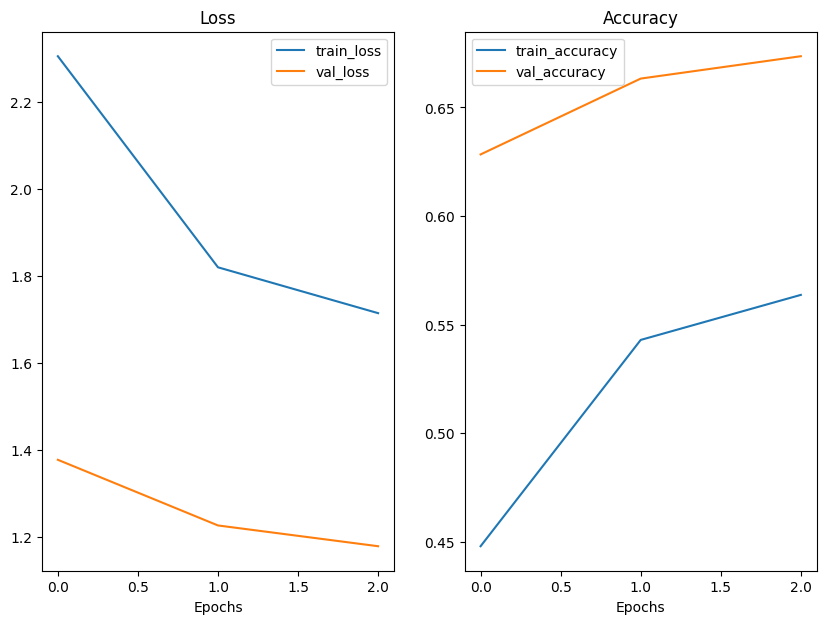

In [ ]:
plot_loss_curves(history_1)


In [ ]:
# Unfreezing top 10 layers for fine-tuning
base_model.trainable=True
for layer in base_model.layers[:-10]:
  layer.trainable=False

In [ ]:
# Fine-tuning
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

extract_epochs = 3
fine_tune_epochs = 3

history_2 = model.fit(train_data,
                      epochs=extract_epochs + fine_tune_epochs,
                      validation_data=val_data,
                      initial_epoch=history_1.epoch[-1])


Epoch 3/6
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 272s 108ms/step - accuracy: 0.5784 - loss: 1.6977 - val_accuracy: 0.7108 - val_loss: 1.0465
Epoch 4/6
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 270s 112ms/step - accuracy: 0.6245 - loss: 1.4825 - val_accuracy: 0.7287 - val_loss: 0.9884
Epoch 5/6
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 265s 112ms/step - accuracy: 0.6363 - loss: 1.4103 - val_accuracy: 0.7383 - val_loss: 0.9510
Epoch 6/6
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 247s 104ms/step - accuracy: 0.6522 - loss: 1.3513 - val_accuracy: 0.7450 - val_loss: 0.9205


In [ ]:
model.evaluate(test_data)

395/395 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.7302 - loss: 0.9720


[0.9278497099876404, 0.7440000176429749]

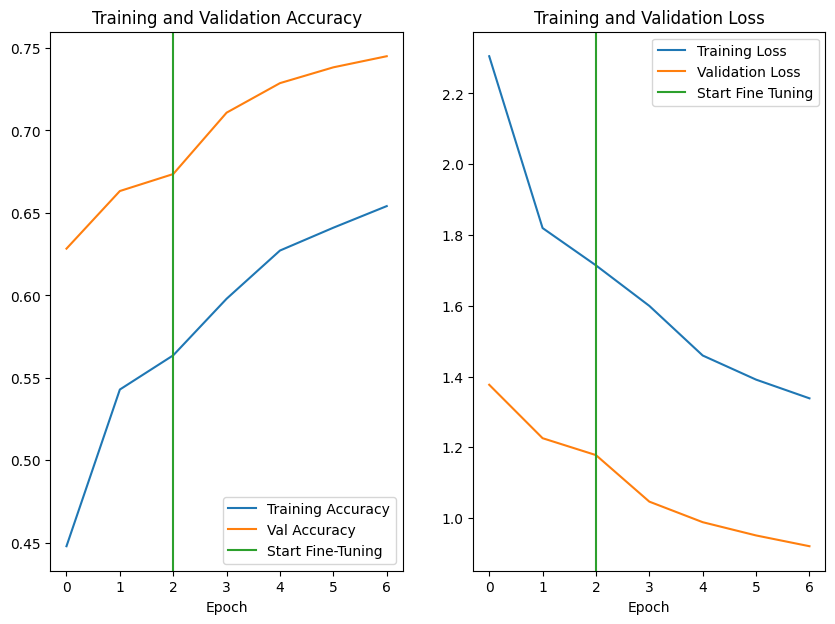

In [ ]:
# Plotting train and validation accuracy and loss curves before and after fine-tuning
acc = history_1.history["accuracy"]
loss = history_1.history["loss"]

val_acc = history_1.history["val_accuracy"]
val_loss = history_1.history["val_loss"]

# Combine original history with new history
total_acc = acc + history_2.history["accuracy"]
total_loss = loss + history_2.history["loss"]

total_val_acc = val_acc + history_2.history["val_accuracy"]
total_val_loss = val_loss + history_2.history["val_loss"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
ax1.plot(total_acc, label="Training Accuracy")
ax1.plot(total_val_acc, label="Val Accuracy")
ax1.plot([extract_epochs-1, extract_epochs-1],
         ax1.set_ylim(), label="Start Fine-Tuning")
ax1.legend()
ax1.set_xlabel("Epoch")
ax1.set_title("Training and Validation Accuracy")

ax2.plot(total_loss, label='Training Loss')
ax2.plot(total_val_loss, label='Validation Loss')
ax2.plot([extract_epochs-1, extract_epochs-1],
          ax2.set_ylim(), label='Start Fine Tuning') # reshift plot around epochs
ax2.legend()
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epoch')
plt.savefig("compare_histories")

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# Getting class names
classes = []
with open("food_101_classes.txt") as f:
    for line in f.readlines():
        classes.append(line.split("\n")[0])

In [ ]:
# Getting test predictions
pred_probs_101 = model.predict(test_data)

395/395 ━━━━━━━━━━━━━━━━━━━━ 39s 80ms/step


In [ ]:
# Getting the highest prediction probability for each prediction
pred_probs = pred_probs_101.max(axis=1)

In [ ]:
# Getting class labels from predictions
pred_labels = tf.argmax(pred_probs_101, axis=1)

In [ ]:
# Getting class names from predicted labels
pred_classes = [classes[i] for i in pred_labels.numpy()]

In [ ]:
# Getting the actual labels for the test data
actual_labels = []
for images, labels in test_data.unbatch():
  actual_labels.append(labels.numpy().argmax())

In [ ]:
# Getting the actual classes for the test data
actual_classes = [classes[i] for i in actual_labels]

In [ ]:
# Getting a list of filepaths for images in the test dataset
filepaths = []
for filepath in test_data.list_files("/content/data/content/all_food_classes/test/*/*.jpg",
                                    shuffle=False):
    filepaths.append(filepath.numpy())

In [ ]:
# Constructing a dataframe with the test data attributes and predictions
import pandas as pd
pred_df = pd.DataFrame({"filepaths": filepaths,
                        "actual_label": actual_labels,
                        "actual_class": actual_classes,
                        "pred_label": pred_labels.numpy(),
                        "pred_class": pred_classes,
                        "pred_prob": pred_probs})

In [ ]:
pred_df.head()

filepaths  actual_label  \
0  b'/content/data/content/all_food_classes/test/...             0   
1  b'/content/data/content/all_food_classes/test/...             0   
2  b'/content/data/content/all_food_classes/test/...             0   
3  b'/content/data/content/all_food_classes/test/...             0   
4  b'/content/data/content/all_food_classes/test/...             0   

  actual_class  pred_label pred_class  pred_prob  
0    apple_pie          85     samosa   0.627203  
1    apple_pie           0  apple_pie   0.668494  
2    apple_pie           0  apple_pie   0.850529  
3    apple_pie           0  apple_pie   0.420784  
4    apple_pie           0  apple_pie   0.357150

In [ ]:
# Getting only the test images that were wrongly predicted
wrong_pred_df = pred_df[pred_df["actual_label"] != pred_df["pred_label"]]

In [ ]:
wrong_pred_df.head()

filepaths  actual_label  \
0   b'/content/data/content/all_food_classes/test/...             0   
7   b'/content/data/content/all_food_classes/test/...             0   
8   b'/content/data/content/all_food_classes/test/...             0   
10  b'/content/data/content/all_food_classes/test/...             0   
11  b'/content/data/content/all_food_classes/test/...             0   

   actual_class  pred_label        pred_class  pred_prob  
0     apple_pie          85            samosa   0.627203  
7     apple_pie           8     bread_pudding   0.431895  
8     apple_pie          57            hummus   0.439402  
10    apple_pie         100           waffles   0.736606  
11    apple_pie          22  chocolate_mousse   0.279025

In [ ]:
wrong_pred_df.sort_values(by=["pred_prob"], ascending=False, inplace=True)

<ipython-input-33-0ca66bf7c25a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrong_pred_df.sort_values(by=["pred_prob"], ascending=False, inplace=True)


In [ ]:
wrong_pred_df.head()

filepaths  actual_label  \
9001  b'/content/data/content/all_food_classes/test/...            72   
5435  b'/content/data/content/all_food_classes/test/...            43   
383   b'/content/data/content/all_food_classes/test/...             3   
5814  b'/content/data/content/all_food_classes/test/...            46   
4338  b'/content/data/content/all_food_classes/test/...            34   

        actual_class  pred_label     pred_class  pred_prob  
9001        pancakes          67       omelette   0.998966  
5435  fried_calamari          68    onion_rings   0.996137  
383   beef_carpaccio          13  caprese_salad   0.995775  
5814    garlic_bread          10     bruschetta   0.993536  
4338   eggs_benedict          86        sashimi   0.991942

In [ ]:
# Function taken from: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into (img_shape, img_shape, color_channels=3)

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """

  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale
  if scale:
    # rescale the image (all values between 0 and 1)
    return img/255.
  else:
    return img

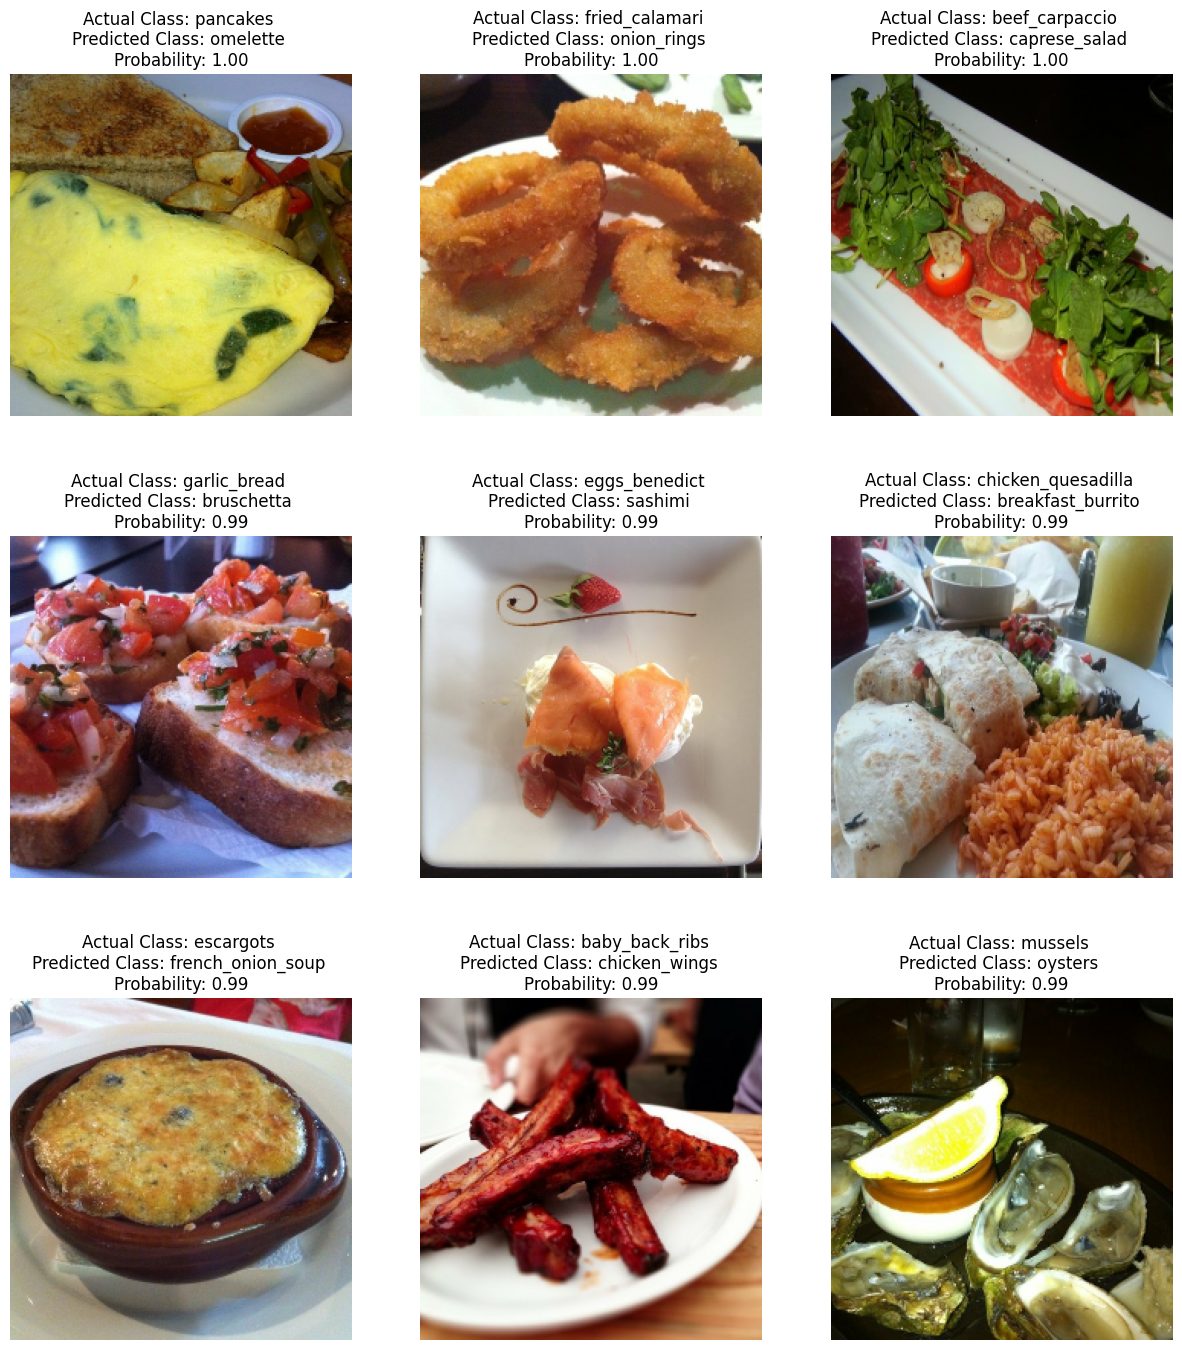

In [ ]:
# Visualizing the model's most wrong predictions
images_to_view = 9
start_index = 0
plt.figure(figsize=(15, 17))
for i, row in enumerate(wrong_pred_df[start_index:start_index+images_to_view].itertuples()):
    plt.subplot(3, 3, i+1)
    _, filepath, _, actual_class, _, pred_class, pred_prob = row
    img = load_and_prep_image(filepath)
    plt.imshow(img)
    plt.title(f"Actual Class: {actual_class} \nPredicted Class: {pred_class} \nProbability: {pred_prob:.2f}")
    plt.axis(False)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
classification_report_dict = classification_report(actual_labels, pred_labels.numpy(), output_dict=True)

In [ ]:
# Getting a dictionary of f1 scores for each class
class_f1_scores = {}
for key, value in classification_report_dict.items():
  if key == "accuracy":
    break
  else:
    class_f1_scores[classes[int(key)]] = value["f1-score"]

In [ ]:
# Making a dataframe to be able to sort by f1 score and later plot the values
f1_scores = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

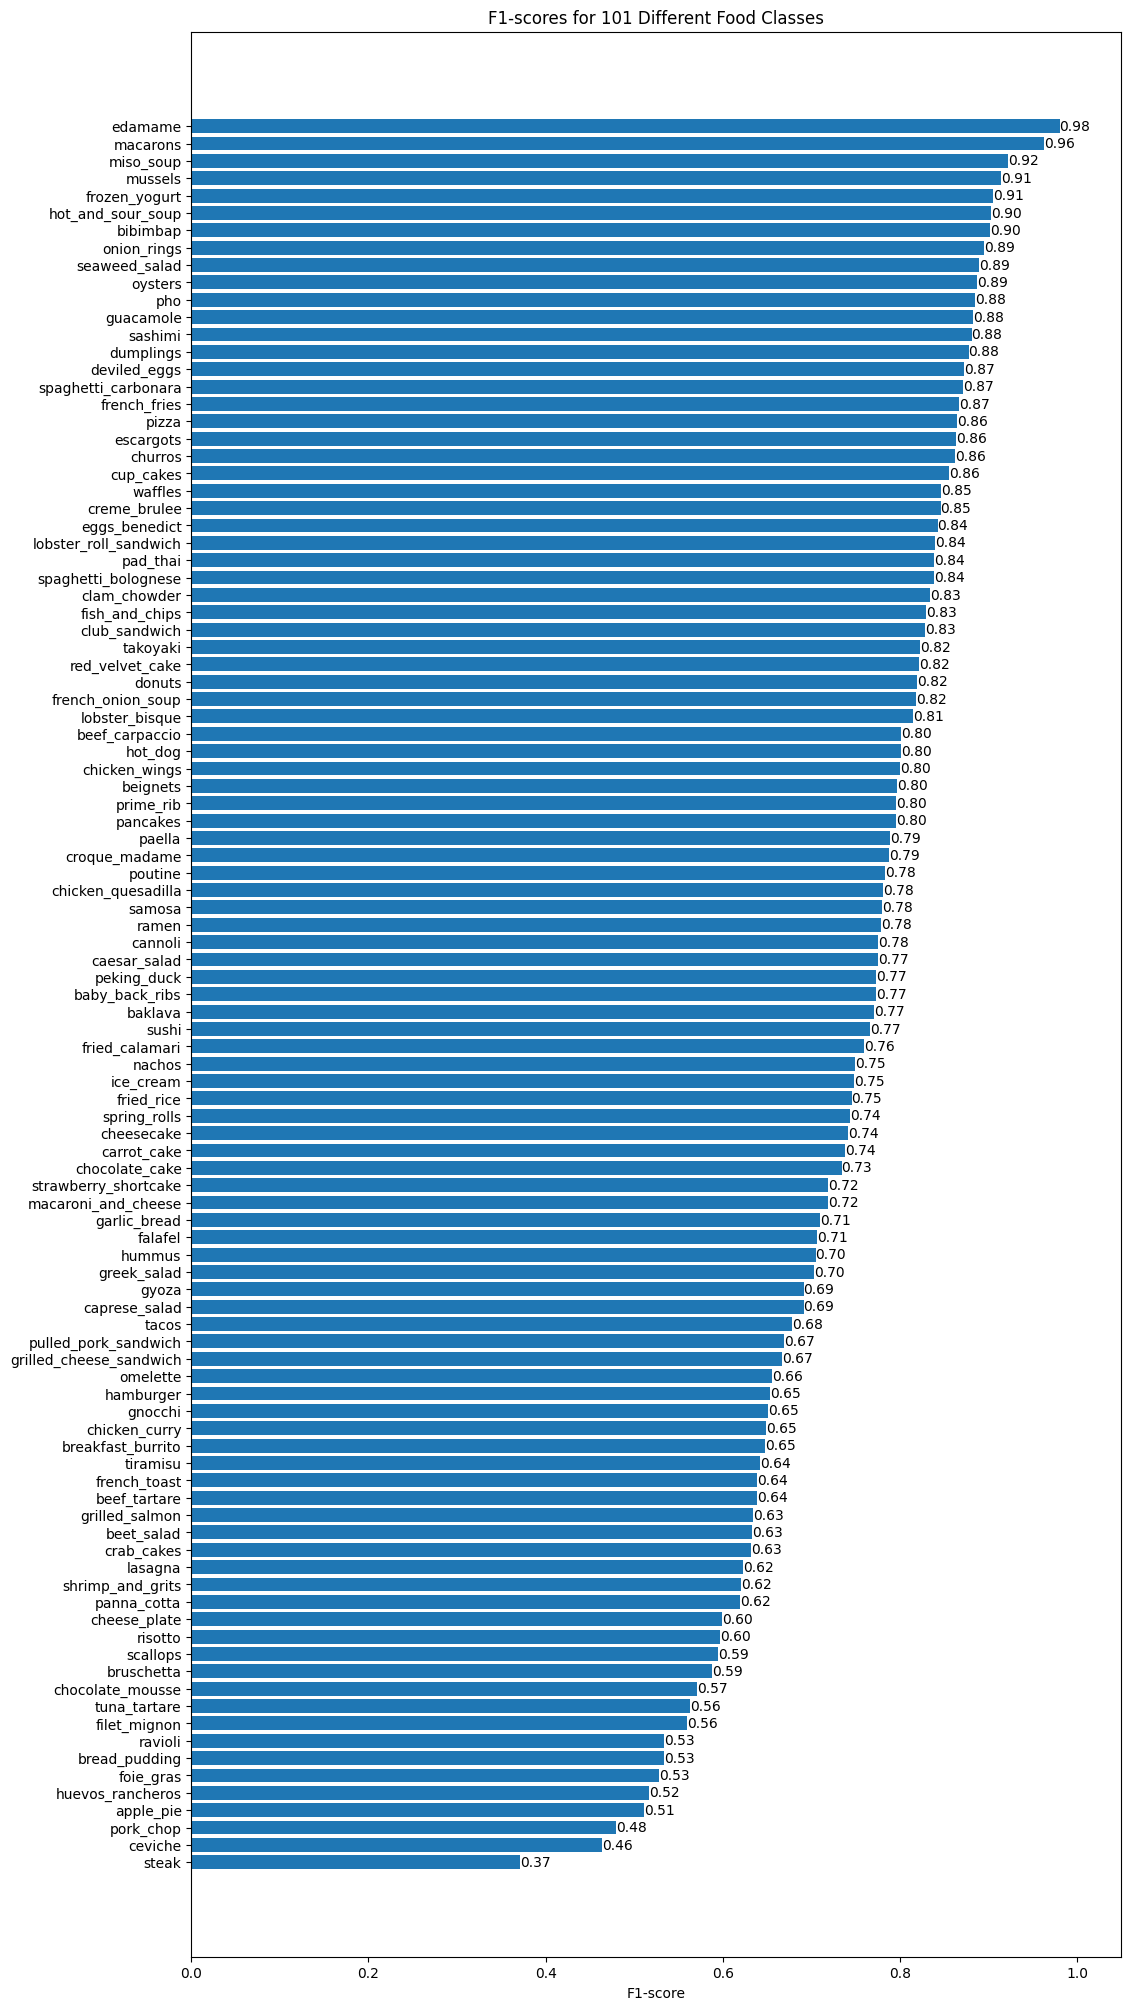

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_xlim(0, 1.05)
ax.set_title("F1-scores for 101 Different Food Classes")
ax.invert_yaxis() # reverse plot order
ax.bar_label(scores, fmt="%.2f")
plt.savefig("food_101_f1_score_hbar")
plt.show();

In [ ]:
# Function taken from: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(actual_labels, pred_labels.numpy(), classes=classes, figsize=(100,100), text_size=20, savefig=True)